In [1]:
%load_ext autoreload
%matplotlib widget
%autoreload 2
from amftrack.pipeline.launching.run_super import (
    run_launcher,
    directory_scratch,
    directory_project,
    directory_project,
    run_parallel_stitch,
    run_parallel_transfer,
)
import os
from amftrack.util.sys import (
    get_dates_datetime,
    get_dirname,
    temp_path,
    get_data_info,
    update_plate_info,
    update_analysis_info,
    get_analysis_info,
    get_current_folders,
    get_folders_by_plate_id,
)
from time import time_ns
from datetime import datetime

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    load_graphs,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_color_value,
    reconstruct_image_from_general,
    plot_full,
    find_nearest_edge,
)
from amftrack.pipeline.functions.image_processing.extract_width_fun import (
    # get_width_info,
    get_width_info_new,
)
import matplotlib.pyplot as plt
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    save_graphs,
)
import pandas as pd
from amftrack.pipeline.functions.spore_processing.spore_id import make_spore_data
from amftrack.pipeline.functions.image_processing.hyphae_id_surf import (
    resolve_anastomosis_crossing_by_root,
)
from amftrack.pipeline.functions.post_processing.time_hypha import *
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
    Edge,
    Hyphae,
)
from datetime import datetime
from matplotlib import cm
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from IPython.display import clear_output
from amftrack.pipeline.functions.post_processing.exp_plot import *
from amftrack.pipeline.launching.run_super import (
    run_parallel,
    run_launcher,
    run_parallel_all_time,
)

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-12-01 14:24:11.281158: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 14:24:11.427269: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 14:24:11.786113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-01 14:24:15.490894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2024-12-01 14:24:19,189-[WARNING]- absl:256 -> Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2024-12-01 14:24:19,204-[WARNING]- absl:184 -> Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


/home/cbisot/miniconda3/envs/amftrack/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [20]:
# Do width

plates = [
	"393_20231129",
	"366_20230921",
	"3_20220426",
	"1045_20220504",
	"559_20230109",
	"219_20230307",
	"252_20230316",
]
plates = ["792_20230324"]
# plates = [
# "50_20240703",
# "59_20240615",
# "60_20240625",
# "69_20240625",
# "72_20240722"
# ]
directory_targ = os.path.join(directory_scratch, "redo_width_temp") + "/"

directory_targ = os.path.join(directory_scratch, "make_temp_graph") + "/"
# directory_targ = "/projects/0/einf914/transport/"
update_plate_info(directory_targ, local=True)
all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"].isin(plates)]
# folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]


analysed:   0%|          | 0/447 [00:00<?, ?it/s]

In [17]:
name_job = "test_realign"
for plate in plates:
    select = folders.loc[folders["unique_id"] == plate]
    num_parallel = 100
    time = "12:00:00"
    args = [directory_targ]
    run_parallel(
        "final_alignment_new.py",
        args,
        select,
        num_parallel,
        time,
        "realign",
        cpus=128,
        node="fat_rome",
        name_job=name_job,
    )

Submitted batch job 8871570
Submitted batch job 8871571
Submitted batch job 8871572
Submitted batch job 8871573
Submitted batch job 8871574


In [6]:
3e6*0.0045*0.432

5831.999999999999

In [18]:
name_job = "test_realign"

for plate in plates:
    select = folders.loc[folders["unique_id"] == plate]
    # select = select.sort_values(by="folder")
    # select = select.iloc[5:]
    num_parallel = 100
    time = "12:00:00"
    args = [directory_targ]
    run_parallel(
        "realign_new2.py",
        args,
        select,
        num_parallel,
        time,
        "create_realign",
        cpus=128,
        node="fat_rome",
        name_job=name_job,
    )

Submitted batch job 8872025
Submitted batch job 8872026
Submitted batch job 8872027
Submitted batch job 8872028
Submitted batch job 8872029


In [19]:
import pickle
import scipy.io as sio

path_root = f"/scratch-shared/amftrack/graph_stacks"

plate_id = "441_20230807"

# update_plate_info(directory_targ, local=True,strong_constraint=False)
# all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="folder")

folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
for i in range(1,len(folders)):
    selection =folders.iloc[i : i + 1]
    folder_list = list(selection["folder"])
    directory_name = folder_list[0]
    path_snap = directory_targ + directory_name
    transform = sio.loadmat(path_snap + "/Analysis/transform_new.mat")
    exp.load(selection, suffix="_realigned")
    for t in range(exp.ts):
        exp.load_tile_information(t)
        exp.save_location = ""
        
        load_study_zone(exp)
    os.makedirs(os.path.join(path_root,plate_id,),exist_ok = True)
    graph = exp.nx_graph[0]
    graph_to_save = graph.copy()
    for u, v, data in graph_to_save.edges(data=True):
        data["pixels"] = data.pop("pixel_list")
    node_not_in_ROI = []
    for node in graph_to_save:
        if not is_in_ROI_node(Node(node, exp), 0):
            node_not_in_ROI.append(node)
    graph_to_save.remove_nodes_from(node_not_in_ROI)
    nx.set_node_attributes(graph_to_save, exp.positions[0], 'position')
    path_tot = os.path.join(path_root,plate_id,f"graph{i:03d}.pickle")
    pickle.dump((graph_to_save,transform,selection.iloc[0]), open(path_tot, 'wb'))
    # break

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-08 02:06:00


In [4]:
from matplotlib import cm
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *

downsizing = 5
def plot_region(region,t,fig,ax,i,imin,imax):
    fig, ax,f = plot_edge_color_value_2(
        exp,
        t,
        lambda edge : i,
        cmap=cm.get_cmap("viridis", 100),
        plot_cmap=True,
        show_background=False,
        dilation=2,
        figsize=(5, 3),
        alpha = 1,
        downsizing = downsizing,
        region = region,
        v_min = imin,
        v_max = imax,
        figax = (fig,ax)
    )
    plt.xticks([])  # Removes 
    plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels

In [49]:
folders.iloc[60]['folder']

'20230813_1006_Plate10'

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-31 15:20:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


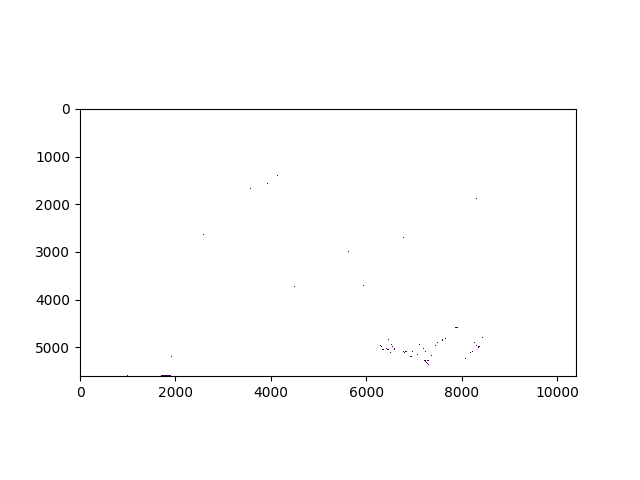

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-09-01 15:43:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


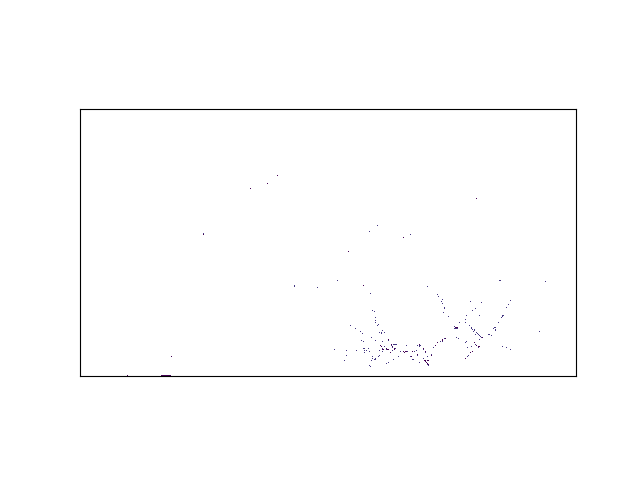

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-09-02 11:43:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


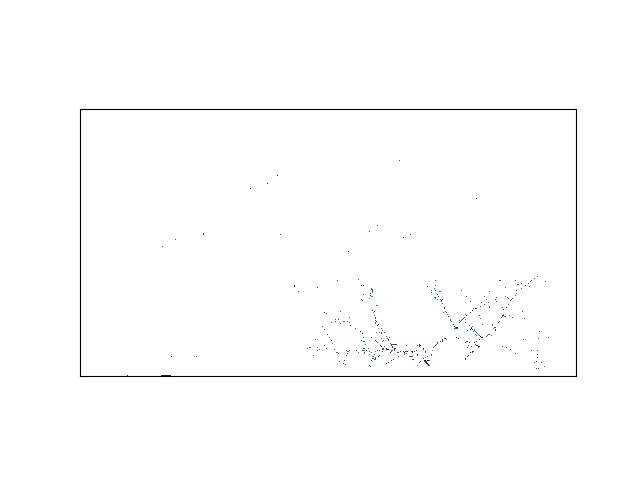

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-09-03 11:43:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


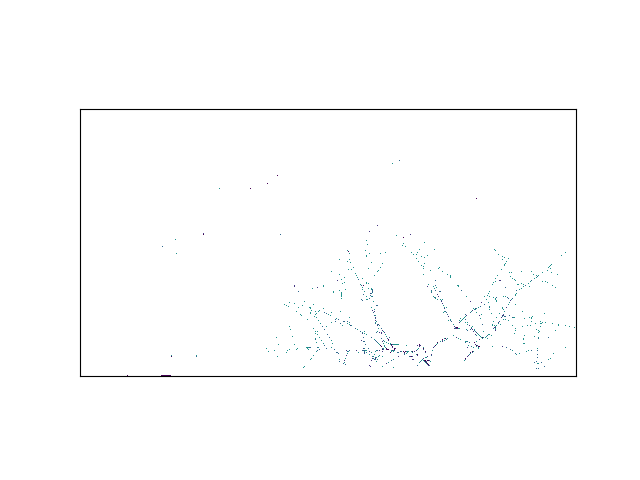

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-09-04 09:42:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


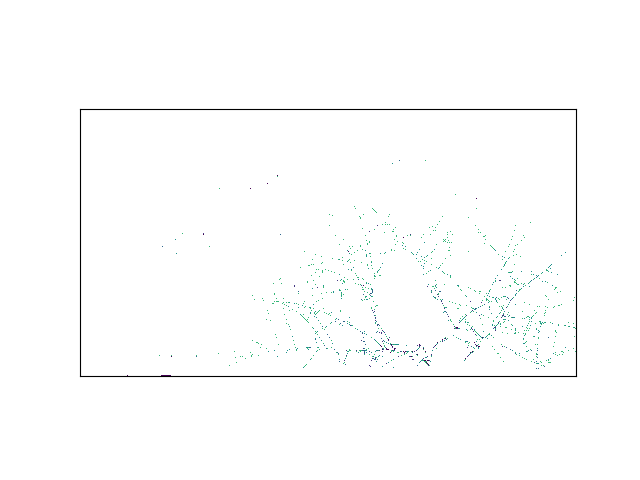

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-09-05 09:45:00


/scratch-local/cbisot/ipykernel_2259938/3737403831.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap("viridis", 100),


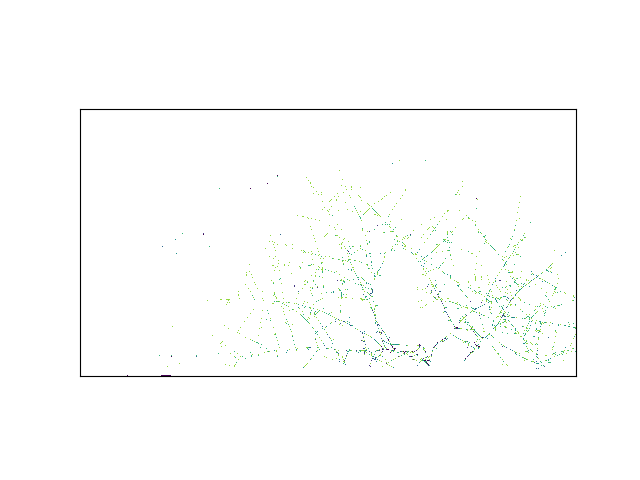

In [50]:
plate_id = "310_20230830"

folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="folder")

folders = folders.sort_values(by="datetime")
downsizing = 5
plt.close('all')
t=0
fig,ax = plt.subplots()
imin = 0
imax = 60
for i in range(imin,imax,10):
    exp = Experiment(directory_targ)
    
    exp.load(folders.iloc[i : i + 1], suffix="_realigned")    
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)
    region = [[0*5,0*5],[28000,52000]]

    # region =  [[4750*downsizing,5000*downsizing],[5250*downsizing,5500*downsizing]]
    plot_region(region,0,fig,ax,i,imin,imax)
    # break

In [8]:
dir_drop = "DATA/PRINCE"
delete = True
run_parallel_transfer(
    "toward_drop.py",
    [dir_drop, delete],
    folders,
    50,
    "4:00:00",
    "staging",
    cpus=1,
    node="staging",
    name_job=name_job,
)

sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052775


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052776


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052777


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052778


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052779


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052780


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052781


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052782


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052783


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052784


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052785


sbatch: Single-node jobs run on a shared node by default. Add --exclusive if you want to use a node exclusively.
sbatch: A full node consists of 32 CPU cores, 229376 MiB of memory and 0 GPUs and can be shared by up to 32 jobs.
sbatch: By default shared jobs get 7168 MiB of memory per CPU core, unless explicitly overridden with --mem-per-cpu, --mem-per-gpu or --mem.
sbatch: You will be charged for 1 CPUs, based on the number of CPUs and the amount memory that you've requested.


Submitted batch job 8052786


In [11]:
folders.iloc[i : i + 1]['folder']

178    20230907_0821_Plate07
Name: folder, dtype: object

In [37]:
plate_id = "310_20230830"

folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="folder")

folders = folders.sort_values(by="datetime")
folder_list = list(folders["folder"])

folder_list[:65]

['20230831_1520_Plate06',
 '20230831_1719_Plate06',
 '20230831_1920_Plate06',
 '20230831_2120_Plate06',
 '20230831_2320_Plate06',
 '20230901_0120_Plate06',
 '20230901_0320_Plate06',
 '20230901_0520_Plate06',
 '20230901_0719_Plate06',
 '20230901_1343_Plate07',
 '20230901_1543_Plate07',
 '20230901_1742_Plate07',
 '20230901_1943_Plate07',
 '20230901_2143_Plate07',
 '20230901_2343_Plate07',
 '20230902_0143_Plate07',
 '20230902_0343_Plate07',
 '20230902_0543_Plate07',
 '20230902_0743_Plate07',
 '20230902_0943_Plate07',
 '20230902_1143_Plate07',
 '20230902_1343_Plate07',
 '20230902_1943_Plate07',
 '20230902_2143_Plate07',
 '20230902_2343_Plate07',
 '20230903_0143_Plate07',
 '20230903_0343_Plate07',
 '20230903_0543_Plate07',
 '20230903_0743_Plate07',
 '20230903_0943_Plate07',
 '20230903_1143_Plate07',
 '20230903_1547_Plate07',
 '20230903_1746_Plate07',
 '20230903_1942_Plate07',
 '20230903_2142_Plate07',
 '20230903_2342_Plate07',
 '20230904_0142_Plate07',
 '20230904_0342_Plate07',
 '20230904_0

In [14]:
plate_id = "449_20230807"

# update_plate_info(directory_targ, local=True,strong_constraint=False)
# all_folders = get_current_folders(directory_targ, local=True)
folders = all_folders.loc[all_folders["unique_id"] == plate_id]
folders = folders.loc[folders["/Analysis/nx_graph_pruned_width.p"] == True]
folders = folders.sort_values(by="folder")

folders = folders.sort_values(by="datetime")

exp = Experiment(directory_targ)
# i = indexes[plate_id_video]
# i = np.where(folders['folder'] == indexes[plate_id_video])[0][0]
# selection = folders[folders['folder'].isin(indexes.values())]
i = 70
exp.load(folders.iloc[i : i + 2], suffix="_realigned")

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["datetime"] = pd.to_datetime(


2023-08-14 10:19:00
2023-08-14 16:19:00


/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-08-11 16:05:00


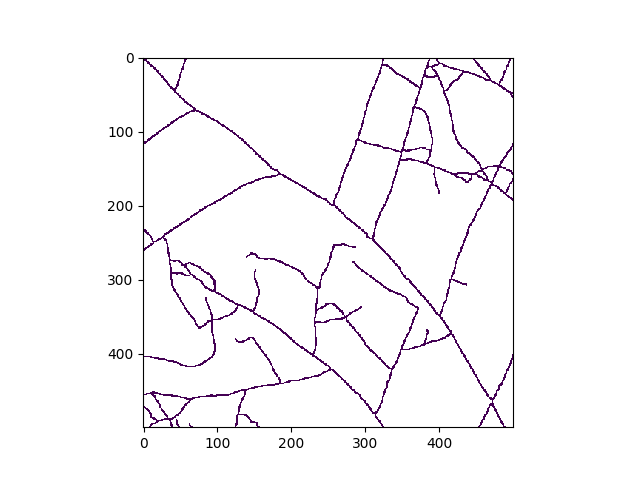

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-08-12 02:05:00


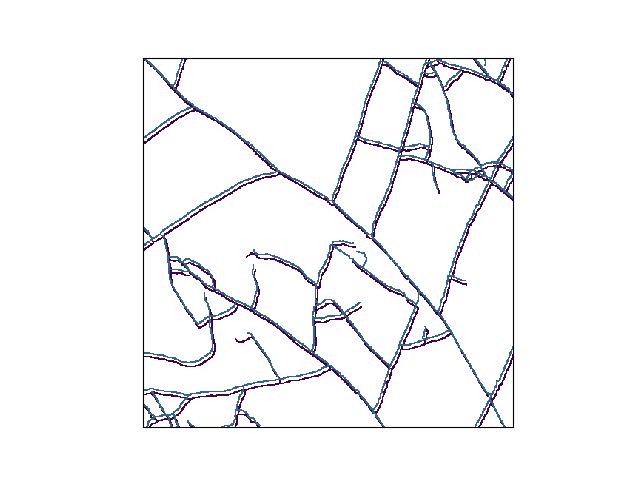

/gpfs/home2/cbisot/pycode/AMFtrack/amftrack/pipeline/functions/image_processing/experiment_class_surf.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.folders["date"], format="%d.%m.%Y, %H:%M:"


2023-08-12 04:06:00


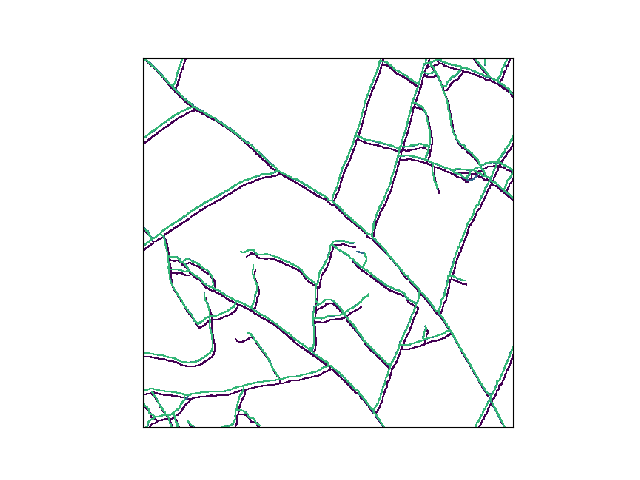

In [45]:
plt.close('all')
t=0
fig,ax = plt.subplots()
imin = 0
imax = 60
for i in range(imin,imax):
    exp.load(folders.iloc[i : i + 1], suffix="_width")    
    exp.load_tile_information(t)
    exp.save_location = ""

    load_study_zone(exp)
    region =  [[4750*downsizing,5000*downsizing],[5250*downsizing,5500*downsizing]]
    plot_region(region,0,fig,ax,i,imin,imax)
    # break

In [48]:
Rot_init

array([[ 9.99999974e-01,  2.28926973e-04],
       [-2.28926973e-04,  9.99999974e-01]])

In [49]:
t_init

array([-61.80308489, -19.83654571])

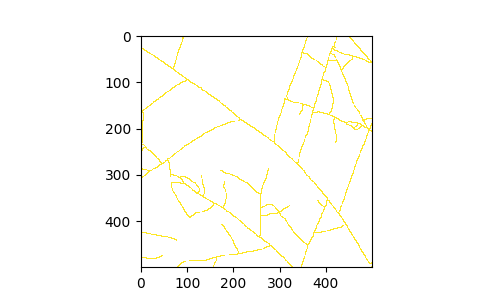

In [27]:
region =  [[4750*downsizing,5000*downsizing],[5250*downsizing,5500*downsizing]]
plot_region(region,1)